In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation
import scipy.signal as sig
import os

In [6]:
d = pd.read_csv('/Users/okkokuisma/projektit/birds/occurence_data/occurrence.txt', sep='\t', skiprows=[5644])

/var/folders/l2/p5w_f2bx6cz7b2p1jb5y5kn00000gn/T/ipykernel_1485/1806180583.py:1: DtypeWarning: Columns (46,208) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('/Users/okkokuisma/projektit/birds/occurence_data/occurrence.txt', sep='\t', skiprows=[5644])


In [3]:
with open('/Users/okkokuisma/projektit/birds/occurence_data/bird_species.txt') as f:
    rows = []
    row = []
    for l in f:
        if not (l.startswith('Lahko') or l.startswith('Heimo') or l.strip() == 'C' or l.strip() == 'B') and l.strip():
            row.append(l.strip())
            if (len(row) == 5):
                rows.append(row)
                row = []

species = pd.DataFrame(rows, columns=['abb', 'scientific', 'finnish', 'swedish', 'english'])
species = species.loc[:, ['scientific', 'finnish', 'english']]
print(species)

                 scientific          finnish                english
0               Cygnus olor     kyhmyjoutsen              Mute Swan
1        Cygnus columbianus     pikkujoutsen          Bewick's Swan
2             Cygnus cygnus     laulujoutsen           Whooper Swan
3             Anser fabalis       metsähanhi             Bean Goose
4      Anser brachyrhynchus  lyhytnokkahanhi      Pink-footed Goose
..                      ...              ...                    ...
487    Emberiza schoeniclus       pajusirkku           Reed Bunting
488        Emberiza pallasi  pikkupajusirkku  Pallas's Reed Bunting
489      Emberiza bruniceps   ruskopääsirkku     Red-headed Bunting
490  Emberiza melanocephala   mustapääsirkku   Black-headed Bunting
491       Emberiza calandra     harmaasirkku           Corn Bunting

[492 rows x 3 columns]


In [7]:
species = pd.read_csv('/Users/okkokuisma/projektit/birds/occurence_data/taxon-export.tsv', sep='\t')
species = species.dropna()
species = species.sort_values('Havaintomäärä Suomesta', ascending=False).iloc[:260, :]

In [8]:
cols = [ 'gbifID', 'species', 'decimalLatitude', 'decimalLongitude' ]
d = d.loc[:, cols]
occurences = d[d['species'].isin(species['Tieteellinen nimi'])]
print(occurences)

            gbifID                 species  decimalLatitude  decimalLongitude
3       4173214155     Emberiza citrinella          48.7565           -1.5103
6       2243564691       Passer domesticus          49.9137           -6.3015
7       4173214157         Sylvia communis          54.1244           -0.5509
13      4173214160  Acrocephalus palustris          51.2389           12.3872
17      4173214162          Motacilla alba          53.0577           14.3099
...            ...                     ...              ...               ...
765531  2243655035          Sylvia curruca          49.0066            8.9213
765536  2243653834       Dendrocopos major          54.1250           -0.5747
765537  2243654688       Turdus philomelos          54.1247           -0.5694
765541  2243655303          Ficedula parva          49.7167           31.5167
765561  2243656839  Phylloscopus collybita          52.9810           19.9040

[241336 rows x 4 columns]


In [6]:
multimedia_df = pd.read_csv('/Users/okkokuisma/projektit/birds/occurence_data/multimedia.txt', sep='\t')

In [7]:
multimedia_df = multimedia_df[multimedia_df['gbifID'].isin(occurences['gbifID'])]
multimedia_df = multimedia_df[multimedia_df['format'] == 'audio/mpeg']
multimedia_df = multimedia_df.reset_index(drop=True)

In [80]:
print(multimedia_df.shape)

(212826, 15)


In [ ]:
test = multimedia_df.loc[100000:, :]
for i, (id, url) in enumerate(zip(test['gbifID'].values, test['identifier'].values)):
    if (i % 10000 == 0):
        print('Downloaded file [%d]/[%d]\r'%(i, multimedia_df.shape[0]), end="")

### Drop species that have less than 50 occurrences

In [ ]:
mask = (occurences.groupby('species').count()['gbifID'] < 50) 
dropped_species = occurences.groupby('species').count()['gbifID'][mask]
occurences = occurences.loc[~occurences['species'].isin(dropped_species.index.to_list()), :]

            gbifID                 species  decimalLatitude  decimalLongitude
3       4173214155     Emberiza citrinella          48.7565           -1.5103
6       2243564691       Passer domesticus          49.9137           -6.3015
7       4173214157         Sylvia communis          54.1244           -0.5509
13      4173214160  Acrocephalus palustris          51.2389           12.3872
17      4173214162          Motacilla alba          53.0577           14.3099
...            ...                     ...              ...               ...
765531  2243655035          Sylvia curruca          49.0066            8.9213
765536  2243653834       Dendrocopos major          54.1250           -0.5747
765537  2243654688       Turdus philomelos          54.1247           -0.5694
765541  2243655303          Ficedula parva          49.7167           31.5167
765561  2243656839  Phylloscopus collybita          52.9810           19.9040

[241040 rows x 4 columns]


In [100]:
print(np.sum((occurences.groupby('species').count()['gbifID'] < 500)))

111


## Signal preprocessing

### Separating bird song from noise

In [ ]:
librosa.load()

In [ ]:
def load_signal(path, sr = 48000):
    signal, sr = librosa.load(path = path, sr = sr)
    return signal

# The frequency range of most bird vocalizations is between 250 Hz and 8.3 kHz
def filter_freqs(signal, sr = 48000, f_highpass = 150, f_lowpass = 10000):
    nyquist = sr / 2.0
    b_hp, a_hp = sig.butter(4, f_highpass/nyquist, btype="highpass")
    b_lp, a_lp = sig.butter(4, f_lowpass/nyquist, btype="lowpass")
    signal_hp = sig.filtfilt(b_hp, a_hp, signal)
    signal = sig.filtfilt(b_lp, a_lp, signal_hp)
    return signal

def calculate_spectrogram(signal, n_fft=512, hop_length=384, win_length=512):
    spectrogram = librosa.stft(
        signal,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann"
    )
    return np.abs(spectrogram)

def separate_bird_song(spectrogram):
    spectrogram_max = np.max(spectrogram)
    spectrogram_normalized = spectrogram / spectrogram_max
    col_means = np.mean(spectrogram_normalized, axis=0)
    row_means = np.mean(spectrogram_normalized, axis=1)
    mask = (spectrogram_normalized >= 3 * col_means) & (spectrogram_normalized >= 3 * row_means[:, np.newaxis])
    masked_spectrogram = np.where(mask, 1, 0)
    be = binary_erosion(masked_spectrogram).astype(masked_spectrogram.dtype)
    bd = binary_dilation(be)
    ind_vec = np.where(np.any(bd, axis=0), 1, 0)
    ind_vec = binary_dilation(binary_dilation(ind_vec).astype(ind_vec.dtype))
    return spectrogram[:, ind_vec][:, :280]

def audio_preprocessing_pipeline(
    path,
    sr = 48000,
    f_highpass = 150,
    f_lowpass = 10000,
    n_fft = 512,
    hop_length = 384,
    win_length = 512
):
    signal = load_signal(path, sr)
    filtered_signal = filter_freqs(signal, sr, f_highpass, f_lowpass)
    spectrogram = calculate_spectrogram(filtered_signal, n_fft, hop_length, win_length)
    signal_segment = separate_bird_song(spectrogram)
    return signal_segment

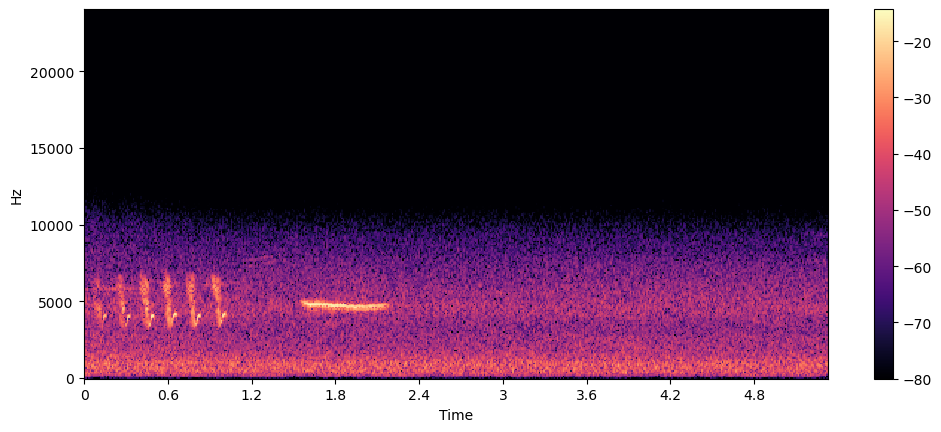

In [ ]:
S_db = librosa.amplitude_to_db(D_abs, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db[:, :500], x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()

In [77]:
n_fft = int(0.0107 * 48000) #  10.7 ms at 48 kHz
hop_length = int(0.008 * 48000) # 0.008 s × 48000 Hz = 384 samples (8 ms)
win_length = 512 # use the full 512‐sample window
DD = librosa.istft(
    D[:, ind_vec],
    n_fft=512,
    hop_length=384,
    win_length=512,
    window="hann"
)
import soundfile as sf

sf.write('stereo_file.wav', DD, sr, subtype='PCM_24')

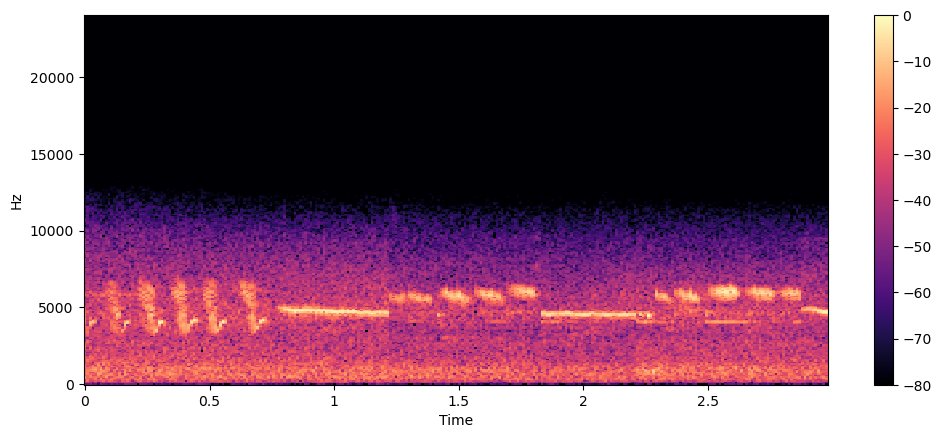

In [5]:
S_db = librosa.amplitude_to_db(D_abs[:, ind_vec][:, :280], ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()

In [53]:
fs = []
for dirpath, dnames, fnames in os.walk("/Volumes/COCO-DATA/songs/"):
    for f in fnames:
        fs.append(f)
print(occurences.loc[occurences['gbifID'].isin(np.array(fs, dtype=int)), :])

            gbifID                 species  decimalLatitude  decimalLongitude
6       2243564691       Passer domesticus          49.9137           -6.3015
24      2243564866       Muscicapa striata          54.1250           -0.5746
26      2243565718       Muscicapa striata          54.1251           -0.5746
28      2243564841       Muscicapa striata          54.1251           -0.5746
29      4173214168               Asio otus          56.1597           15.0889
...            ...                     ...              ...               ...
765531  2243655035          Sylvia curruca          49.0066            8.9213
765536  2243653834       Dendrocopos major          54.1250           -0.5747
765537  2243654688       Turdus philomelos          54.1247           -0.5694
765541  2243655303          Ficedula parva          49.7167           31.5167
765561  2243656839  Phylloscopus collybita          52.9810           19.9040

[211572 rows x 4 columns]


In [80]:
for i, id in enumerate(occurences['gbifID'][:10000].values):
    song_path = f"/Volumes/COCO-DATA/songs/{id}"
    npy_path = f"/Volumes/COCO-DATA/songs_npy/{id}.npy"
    success = 'x'
    if (i % 1000 == 0):
        try:
            if os.path.isfile(song_path):
                segment = audio_preprocessing_pipeline(song_path)
                np.save(npy_path, segment)
                # success = 'o'
        except:
            continue
        # print('Processed file [%d]/[%d]: %s\r'%(i, occurences.shape[0], success), end="")

Note: Illegal Audio-MPEG-Header 0x50455441 at offset 2257941.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


In [66]:
path = '/Volumes/COCO-DATA/songs/2243653834'
npy_path = f"/Volumes/COCO-DATA/songs_npy/2243653834.npy"
segment = audio_preprocessing_pipeline(path)
np.save(npy_path, segment)

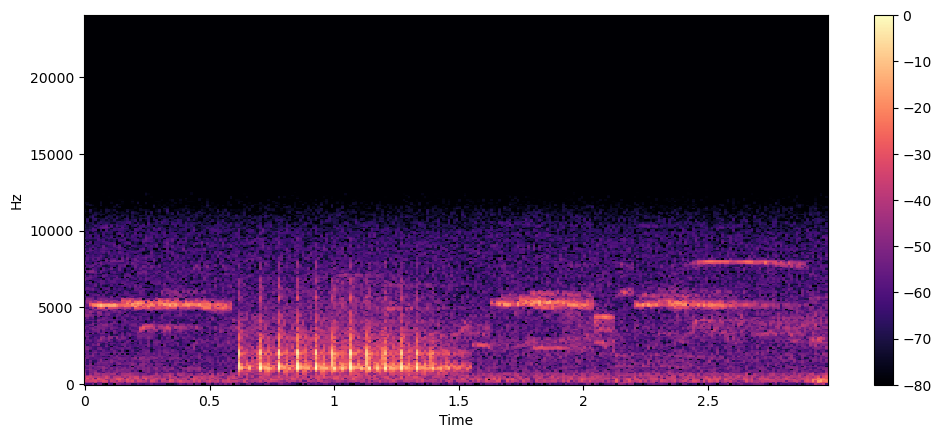

In [67]:
s = np.load(npy_path)
S_db = librosa.amplitude_to_db(s, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()